[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ronzhin-dmitry/GT-VLSI/blob/main/2_Прямоугольные_деревья_Штейнера.ipynb)

In [ ]:
#Для корректного рисования в colab может потребоваться несколько библиотек
# graphviz+lib install
!apt install libgraphviz-dev
!pip install pygraphviz

# Прямоугольные деревья Штейнера

При проектировании микросхем одной из важных задач является трассировка схемы и эффективная укладка дорожек, необходимых для соединения элементов схемы между собой. Возникает вариант задачи нахождения [минимального дерева Штейнера](https://ru.wikipedia.org/wiki/Задача_Штейнера_о_минимальном_дереве) с одним дополнительным ограничением - в силу особенностей производства схем, наиболее выгодной с точки зрения производства является трассировка схемы с использованием [прямоугольной метрики](https://ru.wikipedia.org/wiki/Расстояние_городских_кварталов), то есть трассировка дорожек параллельных сторонам прямоугольной платы. Поиск [прямоугольного Штейнерова дерева](https://ru.wikipedia.org/wiki/Задача_Штейнера_о_минимальном_дереве) является NP-трудной задачей, поэтому на практике (в случае достаточно большого числа элементов, укладываемых на плате) часто используются эффективные алгоритмы, позволяющие построить достаточно точное приближение оптимального решения задачи. Чтобы корректно дать определение прямоугольному дереву Штейнера, необходимо определить несколько вспомогательных терминов - планарные и плоские графы.

**Определение:** Пусть $V$ - конечное множество точек в $\mathbb{R}^2$. Пусть $L$ - множество спрямляемых непрерывных кривых, соединяющих пары точек их $V$. Будем обозначать элементы $L$ через $l = l(v1,v2), v1,v2 \in V$.
Если верно что:

$\forall l=l(v_1,v_2) : l \cap V = \{v_1,v_2\} $,

$\forall l,l' \in L, l=l(v_1,v_2),l'=l'(v_1',v_2') : l \cap l' \subseteq \{v_1,v_2\}\cap\{v_1',v_2'\}$.

Тогда будем называть $(V,L)$ - *плоским графом*.

*Иными словами*, плоским называется такой граф, который изображен на плоскости без пересечения ребер в точках, отличных от вершин графа.

**Определение:** Пусть даны два графа $G_1 = (V_1,E_1)$ и $G_2 = (V_2,E_2)$ и пусть существует такое биективное отображение $f$ из множества вершин $V_1$ во множество вершин $V_2$, что вершины $f(v_1),f(v_2) \in V_2, \forall v_1,v_2 \in V_1$ смежны тогда и только тогда, когда смежны их прообразы (т.е. смежны вершины $v_1,v_2$). Тогда графы $G_1,G_2$ будем называть изоморфными и обозначать это отношение через $G_1 \cong G_2$.

**Определение:** Пусть $G = (V,E)$ и пусть $G'$ - плоский граф. Если $G \cong G'$, тогда граф $G$ называется планарным.

*Иными словами*, планарным называется граф, который может быть изображен на плоскости без пересечений ребер в точках, отличных от веришн графа.

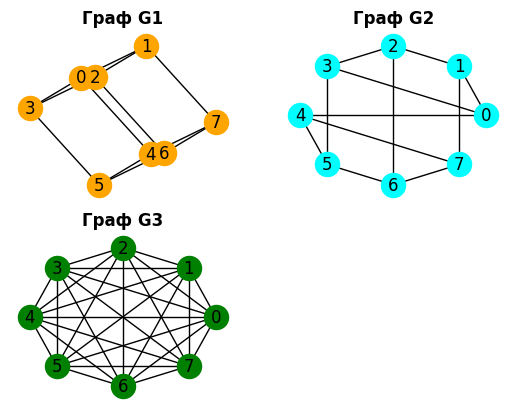

Графы G1 и G2 изоморфны: True
Графы G2 и G3 изоморфны: False
Граф G1 планарен: True
Граф G3 планарен: False


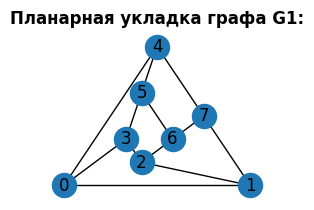

In [3]:
#Рассмотрим несколько примеров, которые демонстрируют понятия планарности
#и изоморфизма графов. В примере ниже все три графа построены на 8 вершинах.
#При этом графы G1 и G2 по существу одинаковы - они отличаются только
#представлением на плоскости. Граф G3 отличен от G1 и G2 потому что нельзя
#так переобозначить вершины графа G3 чтобы он повторил структуру G1.
#При этом, если у графа G1 (и соответственно G2) существует представление
#на плоскости без пересечений рёбер (планарная укладка), то у G3 такого
#представления нет

import networkx as nx
import matplotlib.pyplot as plt
plt.subplot(221)
G1 = nx.cubical_graph()
nx.draw_spectral(G1, with_labels=True, node_color="orange")
plt.title("Граф G1", fontweight="bold")
G2 = nx.cubical_graph()
plt.subplot(222)
nx.draw_circular(G2, with_labels=True, node_color="cyan")
plt.title("Граф G2", fontweight="bold")
G3 = nx.complete_graph(8)
plt.subplot(223)
nx.draw_circular(G3, with_labels=True, node_color="green")
plt.title("Граф G3", fontweight="bold")

plt.show()

print('Графы G1 и G2 изоморфны:', nx.is_isomorphic(G1, G2))
print('Графы G2 и G3 изоморфны:', nx.is_isomorphic(G2, G3))
print('Граф G1 планарен:', nx.check_planarity(G1)[0])
print('Граф G3 планарен:', nx.check_planarity(G3)[0])

plt.subplot(224)
nx.draw_planar(G1, with_labels=True,)
plt.title("Планарная укладка графа G1:", fontweight="bold")
plt.show()

## Задача 1:
Одним из первых теорией графов занялся Леонард Эйлер, когда задумался над решением задачи о семи мостах в Кёнигсберге. Подробнее этой задачей мы займёмся в разделе про поиск эйлеровых циклов в графе, а сейчас попробуем просто осмыслить графовое представление. Взгляните на карту мостов старого Кёнигсберга:


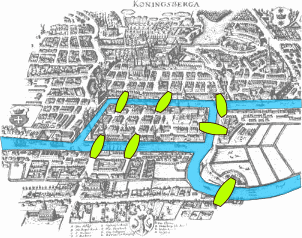

Основная задача заключалась в том, можно ли пересечь все семь мостов, не проходя по каждому более одного раза. Мы же сейчас сделаем первый шаг в решении этой задачи: изобразите с помощью графа карту мостов Кёнигсберга, приняв за вершины четыре района на карте, а за ребра - мосты. Постройте этот граф средствами библиотеки networkx, изобразите его средствами рисования. Ответьте на два простых вопроса:
1. Является ли граф планарным? (какой класс графов автоматически можно назвать планарным?)
2. Изоморфен ли этого граф полному графу на четырех вершинах?

In [4]:
#Ваш код решения задачи 1 должен быть здесь
G = nx.Graph()


**Определение:** Пусть $G = (V,L)$ - плоский граф и задана прямоугольная Декартова система координат $Oxy$. Пусть также $L$ является множество ломанных, причем $\forall l \in L$ звенья ломаной $l$ параллельны либо оси $Ox$ либо оси $Oy$. Тогда граф $G$ будем называть Штейнеровым прямоугольным графом.

**Определение:** Рассмотрим некоторое конечное множество точек $V_1 \subset \mathbb{R}^2$, и будем строить Штейнеровы прямоугольные графы, вершины которых *содержат* множество $V_1$. Среди множества всех упомянутых Штейнеровых прямоугольных выберем **дерево минимальной длины** (по прямоугольной метрике на ребрах графах) - такой граф будем называть **минимальным прямоугольным Штейнеровым деревом** для множества $V_1$.



Рассмотрим пример графа на прямоугольной сетке. Красным цветом отмечены вершины, которые мы объединяем на сетке при помощи Штейнерова дерева. Оранжевым отмечены вспомогательные вершины, через которые проходит дерево, однако они не являются "целевыми". Красным отмечены ребра в МПШД (минимальном прямоугольном Штейнеровом дереве), заметим что вес дерева равен 4, если считать длину каждого ребра единичной. Также заметим, что вершину (3,1) можно не считать вспомогательной, поскольку в неё взодит только два ребра - по существу она является всего лишь звеном ломаной. Здесь и далее мы отмечаем её на изображении только из соображений удобства восприятия информации.

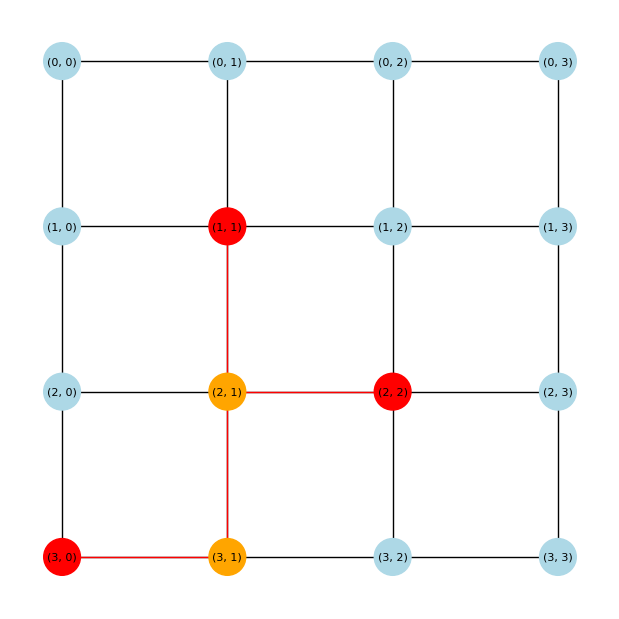

In [5]:
G = nx.grid_2d_graph(4,4)

plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}

val_map = {(3, 0): 'red',
           (2, 2): 'red',
           (1, 1): 'red',
           (2, 1): 'orange',
           (3, 1): 'orange'}
values = [val_map.get(node, 'lightblue') for node in G.nodes()]

nx.draw(G, pos=pos,
        node_color=values,
        with_labels=True,
        node_size=700, font_size = 8)

steiner_edges = [((3,0),(3,1)), ((3,1),(2,1)), ((2,1),(2,2)), ((2,1),(1,1))]
nx.draw_networkx_edges(G, pos, edgelist = steiner_edges, edge_color = "red", alpha=1)

## Задача 2:
Рассмотрим другой набор целевых вершин (их также называют терминальными), а именно вершины (3,1), (2,3), (1,0), (0,1). Изобразите минимальное Штейнерово дерево для данного набора вершин, посчитайте вес этого дерева..

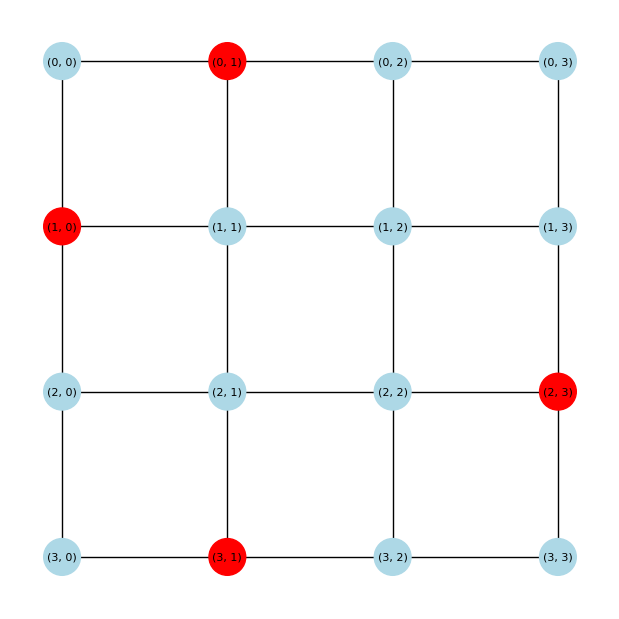

In [6]:
G = nx.grid_2d_graph(4,4)

plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}

val_map = {(3, 1): 'red',
           (2, 3): 'red',
           (1, 0): 'red',
           (0, 1): 'red'}
values = [val_map.get(node, 'lightblue') for node in G.nodes()]

nx.draw(G, pos=pos,
        node_color=values,
        with_labels=True,
        node_size=700, font_size = 8)

steiner_edges = [] #Здесь как было выше перечислите ребра, принадлежащие МПДШ
nx.draw_networkx_edges(G, pos, edgelist = steiner_edges, edge_color = "red", alpha=1)
plt.show()

Мы будем работать с упрощенными примерами, когда вес каждого ребра равен единице (сетка равномерная), однако в реальных приложениях работа с равномерной сеткой может быть не так удобна, и алгоритмы могут работать с графами на сетке, проведенной перпендикулярно координатным осям, проходящей через целевые точки множества. Это не приводит к ухудшению финального результата, но может уменьшить сложность.

Тем не менее, даже для упрощенного случая нахождение точного решения задачи МПШД может быть вычислительно сложным, особенно если число элементов на сетке велико. Наивный переборный алгоритм гарантированно приведен к нужному результату, но потребует большого числа вычислений.

Рассмотрим снова граф из первого примера выше и попробуем написать для него наивный переборный алгоритм.

Целевые вершины на сетке:


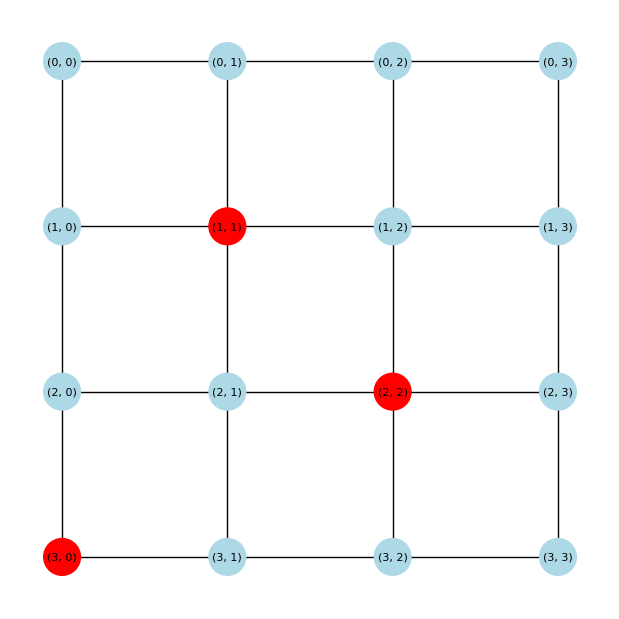

Найденное МШПД путем наивного перебора:


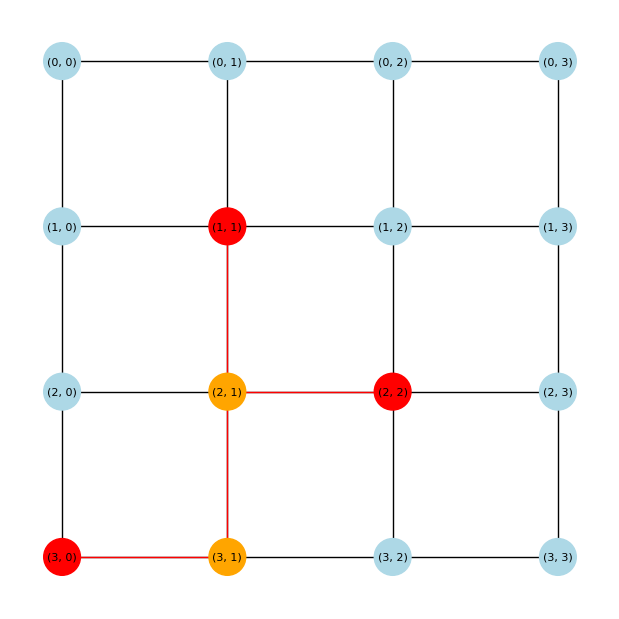

Вес МШПД: 4
Времени затрачено на поиск (в секундах): 1.2823424339294434


In [7]:
G = nx.grid_2d_graph(4,4)

plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}

val_map = {(3, 0): 'red',
           (2, 2): 'red',
           (1, 1): 'red'}
values = [val_map.get(node, 'lightblue') for node in G.nodes()]

nx.draw(G, pos=pos,
        node_color=values,
        with_labels=True,
        node_size=700, font_size = 8)

print('Целевые вершины на сетке:')
nx.draw_networkx_edges(G, pos, edgelist = steiner_edges, edge_color = "red", alpha=1)
plt.show()


#воспользуемся простой функцией для перебора всех подмножеств данного множества
from itertools import chain, combinations
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#Наивный переборный алгоритм.
#Рассмотрим все подграфы, получаемые из G на указанном множестве вершин
#в подграфе будут включены все ребра, которые возможно
#множество вершин обязательно будет включать терминальные
#если подграф связен - найдем его МОД и посчитаем его вес
#выберем минимальное из всех МОД в переборе
def find_min_steiner_naive(G, terminal_nodes):
  min_st_len = len(G.edges())
  min_st = G
  #выделим вершины, которые не являются терминальными в нашей сетке
  remaining_nodes = set(G.nodes) - set(terminal_nodes)
  for node_coll in powerset(remaining_nodes):
    cur_nodes = list(node_coll) + terminal_nodes
    H = nx.induced_subgraph(G, cur_nodes)
    if not nx.is_connected(H):
      continue
    T = nx.minimum_spanning_tree(H)
    if len(T.edges()) < min_st_len:
      min_st_len = len(T.edges)
      min_st = T
  return min_st, min_st_len

import time
terminal_nodes = [(3,0),(2,2),(1,1)] #целевые вершины
start = time.time()
min_st, min_st_len = find_min_steiner_naive(G, terminal_nodes)
end = time.time()
plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}

val_map = {(3, 0): 'red',
           (2, 2): 'red',
           (1, 1): 'red'}
for node in min_st.nodes():
  if node not in val_map:
    val_map[node] = 'orange' #добавляем цвет вспомогательным вершинам

values = [val_map.get(node, 'lightblue') for node in G.nodes()]

nx.draw(G, pos=pos,
        node_color=values,
        with_labels=True,
        node_size=700, font_size = 8)
print('Найденное МШПД путем наивного перебора:')
nx.draw_networkx_edges(min_st, pos, edge_color = "red", alpha=1)
plt.show()

print('Вес МШПД:', min_st_len)
print('Времени затрачено на поиск (в секундах):', end - start)

Сложность переборного алгоритма растет экспоненциально с числом элементов и размером сетки, он довольно быстро становится неприменимым в реальных сценариях. Многие алгоритмы поиска эффективной укладки опираются на приближения к оптимальному решению. Одной из неплохих отправных точек может служить [прямоугольное минимальное остовное дерево](https://ru.wikipedia.org/wiki/Прямоугольное_наименьшее_остовное_дерево). В курсе лекций Вы слышали доказательство того, что длина такого дерева будет не более чем в два раза превышать длину МШПД (эта оценка может быть улучшена до 1.5, см. [статью](https://pdffox.com/on-steiner-minimal-trees-with-rectilinear-distance-pdf-free.html)). При этом, сложность такого построения - полиномиальна и является приемлемой даже для достаточно больших размеров задач.

## Задача 3:
Ниже приведен пример, как можно организовать поиск прямоугольного МОД среди терминальных вершин. Вам необходимо реализовать укладку найденного прямоугольного МОД на решетке, путем добавления вспомогательных вершин. Протестируйте корректность алгоритма и визуализации укладки на задаче большего размера (сетке 16x16, 10 терминальных вершин).

Время затраченное на поиск прямоугольного МОД (секунды): 0.001050710678100586
Вес найденного МОД: 5.0
Структура найденного ПМОД с весами ребер:


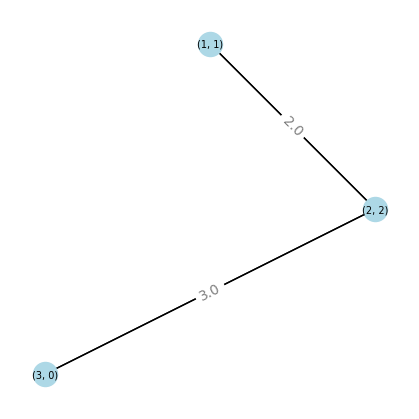

Укладка найденного ПМОД на сетке:


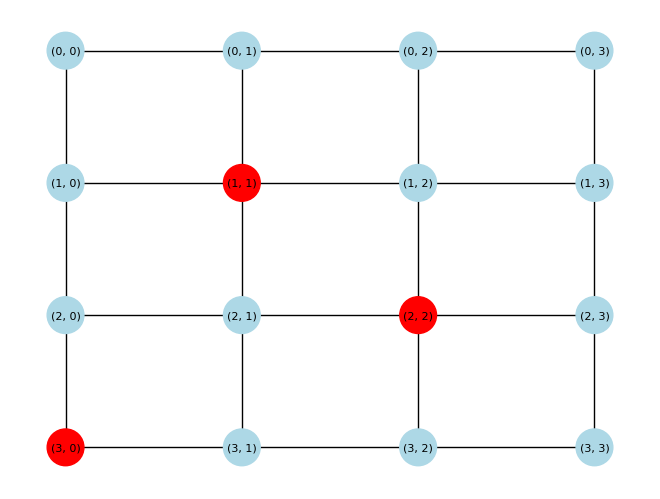

In [34]:
from scipy.spatial.distance import cityblock
from sklearn.metrics.pairwise import pairwise_distances
import time

def find_min_steiner_approximation_MST(terminal_nodes, grid_size = (4,4)):
  terminal_nodes_mapping = {}
  for i in range(len(terminal_nodes)):
    terminal_nodes_mapping[i] = terminal_nodes[i]
  begin = time.time()
  #строим матрицу расстояний в метрике Манхэттена через pairwise_distances
  #инициализируем граф через матрицу расстояний - в нем будем искать МОД
  G2 = nx.from_numpy_array(pairwise_distances(terminal_nodes, terminal_nodes, metric='cityblock'))
  T = nx.minimum_spanning_tree(G2)
  end = time.time()
  T = nx.relabel_nodes(T, terminal_nodes_mapping)
  print('Время затраченное на поиск прямоугольного МОД (секунды):', end-begin)
  print('Вес найденного МОД:',T.size('weight'))
  plt.figure(figsize=(4,4))
  edge_labels = dict([((n1, n2), T[n1][n2]['weight'])
                      for n1, n2 in T.edges])
  nx.draw(T, pos, with_labels = True, font_size = 7, node_color = 'lightblue')
  nx.draw_networkx_edges(T, pos, edge_color = "black", alpha=1)
  nx.draw_networkx_edge_labels(T, pos, edge_labels, alpha = 0.5)
  print('Структура найденного ПМОД с весами ребер:')
  plt.show()
  G = nx.grid_2d_graph(grid_size[0],grid_size[1])
  print('Укладка найденного ПМОД на сетке:')
  val_map = {}
  for node in terminal_nodes:
    val_map[node] = 'red'
  values = [val_map.get(node, 'lightblue') for node in G.nodes()]
  nx.draw(G, pos=pos,
          node_color=values,
          with_labels=True,
          node_size=700, font_size = 8)
  #########################################################
  #TODO: Ваш код здесь, реализуйте визуализацию укладки МОД
  #########################################################
  plt.show()

terminal_nodes = [(3,0),(2,2),(1,1)] #целевые вершины
find_min_steiner_approximation_MST(terminal_nodes) #пример вызова

#TODO: тест на задаче большего размера
#terminal_nodes = ...
#find_min_steiner_approximation_MST(terminal_nodes)

##Эвристика -  минимальное штейнерово прямоугольное дерево с единым остовом

[Single-trunk Steiner Tree](https://en.wikipedia.org/wiki/Rectilinear_Steiner_tree)

В качестве аппроксимации для минимального прямоугольного Штейнерова дерева может быть использован прямоугольный граф с единственной горизонтальной (или вертикальной) "полосой" - остовом, и множеством ребер, которые соединяют терминальные вершины с построенным остовом.

Для блансировки полученного решения и минимизации длины полученного приближения, алгоритм выбирает в качетсве координаты для остова медиану среди всех терминальных точек (медиану по оси ординат, в случае горизонтального остова). **Контрольный вопрос для самопроверки**: почему выбор в качестве положения остова медины минимизирует длину полученного дерева?

Рассмотрим пример работы алгоритма на примере задачи с сеткой 6x6.

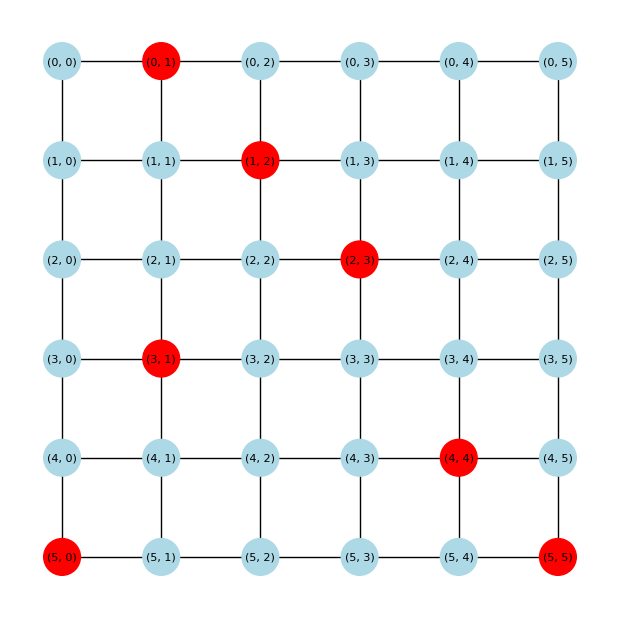

In [59]:
G = nx.grid_2d_graph(6,6)

plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}

terminal_nodes = [(3,1),(2,3),(1,2),(0,1),(4,4),(5,5),(5,0)]

val_map = {}
for node in terminal_nodes:
  val_map[node] = 'red'
values = [val_map.get(node, 'lightblue') for node in G.nodes()]

nx.draw(G, pos=pos,
        node_color=values,
        with_labels=True,
        node_size=700, font_size = 8)

plt.show()

MSTST (Minimum Single Trunk Steiner Tree) алгоритм работает следующим образом:
1. Определяется медиана по одной из осей (например ординат) среди всех терминальных точек
2. Проводится "остов" по выбранной координате
3. Все терминальные вершины, непокрытые остовом, соединяются с остовом при помощи вспомогательных вершин.

Наивная имплементация алгоритма приведена ниже. Мы не замеряем время исполнения этой процедуры, поскольку она реализована неоптимальным образом. Заметим, что [поиск медианы может быть выполнен за линейное время](https://habr.com/ru/articles/346930), и это дает нам теоретическую оценку на вычислительную сложность этой простой эвристики.

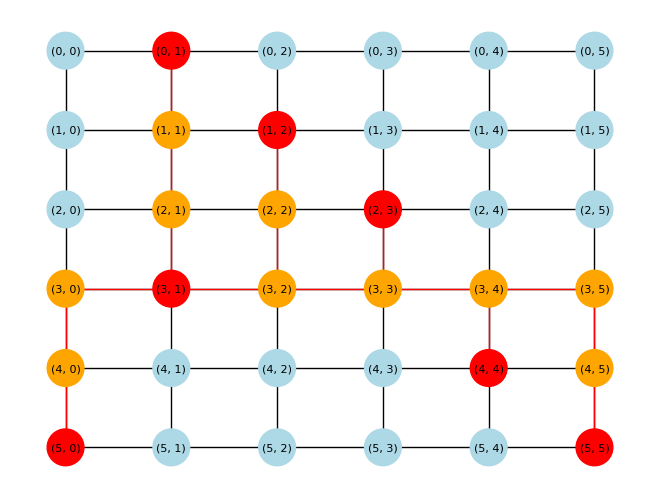

In [64]:
import numpy as np
np_terminal_nodes = np.array(terminal_nodes)
median = int(np.median(np_terminal_nodes[:,0]))
mstst_nodes = [(median,x) for x in range(6)]
for node in terminal_nodes:
  if node[0] != median:
    counter = node[0]
    while(counter != median):
      mstst_nodes.append((counter, node[1]))
      if counter > median:
        counter -= 1
      else:
        counter += 1
val_map = {}

for node in terminal_nodes:
  val_map[node] = 'red'

for node in mstst_nodes:
  if node not in val_map:
    val_map[node] = 'orange'
values = [val_map.get(node, 'lightblue') for node in G.nodes()]

nx.draw(G, pos=pos,
        node_color=values,
        with_labels=True,
        node_size=700, font_size = 8)

mstst_edges = [((median, 0), (median,5))]
for node in terminal_nodes:
  mstst_edges.append((node, (median, node[1])))
nx.draw_networkx_edges(G, pos, edgelist = mstst_edges, edge_color = "red", alpha=1)

plt.show()

ЗАметим, что в качестве направления для остова можно попробовать как горизонтальное, так и вертикальное, и выбрать наикратчайший получившийся граф в качестве приближенного ответа.

Несмотря на низкую сложность реализации, недостатки подхода очевидны - построенное приближение чрезвычайно избыточно и содержит очень много лишних рёбер.

К примеру, цепь от вершины (1,2) до вершины (3,2) на рисунке выше не нужна - достаточно было бы соединить вершины (1,1) и (1,2), что укоротило бы длину построенного дерева на единицу.

В качестве чуть более сложной альтернативы данному подходу был предложен [алгоритм RST-T](https://www.researchgate.net/publication/221031532_Refined_Single_Trunk_Tree_A_Rectilinear_Steiner_Tree_Generator_for_Interconnect_Prediction) который позволяет проводить не одну горизонтальную (или вертикальную) ось-остов, но несколько вспомогательных соединений, для уменьшения общей длины дерева.

#Задача 4 (*):
Реализуйте алгоритм RST-T. Оцените на какую величину получаемое приближение при помощи алгоритма RST-T лучше чем в алгоритме MSTST. Оцените сложность алгоритма RST-T (см. статью выше).

In [53]:
#########################
##TODO: Ваш код здесь####
#########################

## Задача 5 (*):
В данном материале мы рассмотрели упрощенную формулировку задачи, в которой отсутствует важное ограничительное условие - мы считаем что наша сетка содержит только терминальные и вспомогательные вершины. Однако, в реальном синтезе схем, помимо этих двух типов вершин присутствуют так называемые **запрещенные вершины** - это элементы на сетке, которые нельзя использовать как вспомогательные - как правило в синтезе БИС эти позиции соответствуют "проколам" на слое платы. Реализуйте наивный алгоритм и любую из эвристик для получения приближенного решения таким образом, чтобы она поддерживала обработку запрещенных вершин на сетке - и не позволяла алгоритму использовать их в качестве вспомогательных. Перечень запрещенных вершин считать входным параметром для задачи.


In [65]:
#########################
##TODO: Ваш код здесь####
#########################